### 这里是对有限差分法进行整理的gk，我将会把我所理解的一维、二维以及时间方程的有限差分法代码整理出来，以供以后的需要。

### 对于实例，我会用当时所研究的SPDEs来进行举例说明。

# 常微分方程

#### 一维线性方程1: $\begin{cases}\varepsilon u_{xx} + u_x = 1, \ x\in (0,1)\\ u(0)= \, u(1)=1 \\\end{cases}$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import timeit

# 参数设置
epsilon = 0.00001 # 摄动参数
N = 600000 # 划分的网格数，通常要取较大值，以应对小epsilon
x = np.linspace(0, 1, N+1) # x划分的网格点，考虑到0也是一个点，所以N+1个点
h = 1.0 / N # 网格间距

# 右端项函数f(x)，这里取f(x)=1
def f(x):
    return np.cos(2 * np.pi * x)

# 边界条件
u0, u1 = 1, -1

# 初始化矩阵和右端项F
main_diag = np.zeros(N-1) # 主对角线元素
lower_diag = np.zeros(N-2) # 下对角线元素
upper_diag = np.zeros(N-2) # 上对角线元素
F = np.zeros(N-1) # 右端项

# 填充三对角线和右端项F
a = timeit.default_timer()
for i in range(1, N):
    i_row = i - 1
    xi = x[i]
    
    # 有限差分离散化
    a_im1 = epsilon / h**2 - 1/h
    a_i = -2 * epsilon / h**2 + 1/h
    a_ip1 = epsilon / h**2
    
    # 填充矩阵元素
    main_diag[i_row] = a_i
    if i > 1:
        lower_diag[i_row - 1] = a_im1
    if i < N-1:
        upper_diag[i_row] = a_ip1
    
    # 右端项及边界条件处理
    F[i_row] = f(xi)
    # 左边界
    if i == 1:
        F[i_row] -= a_im1 * u0
    # 右边界
    if i == N-1:
        F[i_row] -= a_ip1 * u1

# 构建并求解稀疏矩阵
A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format='csr')
U_internal = spsolve(A, F)

# 统计计算时长
b = timeit.default_timer() - a
print('Time for compute %.2f s' % (b))

# 合并边界值
U = np.zeros(N+1)
U[0] = u0
U[-1] = u1
U[1:-1] = U_internal

plt.plot(x, U, 'b-', linewidth=1.5, label='numerical')
plt.xlabel('x', fontsize=12)
plt.ylabel('u', fontsize=12)
# plt.title(f'ε = {epsilon}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 计算残差
residual = np.zeros(N-1)
for i in range(1, N):
    xi = x[i]
    
    u_xx = (U[i+1] - 2*U[i] + U[i-1]) / h**2
    
    # u_x = (U[i+1] - U[i-1]) / (2 * h)  
    if i == 1:  # 左边界
        u_x = (U[i] - U[i-1]) / h # u_x ≈ (u_i - u_{i-1})/h
    elif i == N-1:  # 右边界
        u_x = (U[i+1] - U[i]) / h # u_x ≈ (u_{i+1} - u_i)/h
    else:  # 内部节点
        u_x = (U[i] - U[i-1]) / h
    
    residual[i-1] = epsilon * u_xx + u_x - f(xi)

print(f"修正后的最大残差：{np.max(np.abs(residual)):.2e}")

# 存储数据(x,u)
# np.savetxt('Example1.csv', np.column_stack((x, U)), delimiter=',')

Time for compute 0.28 s


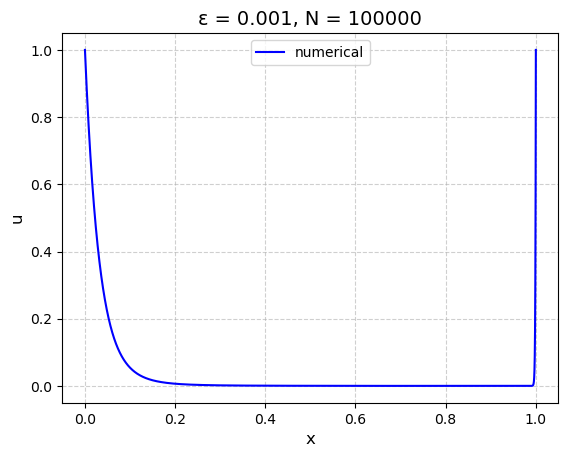

修正后的最大残差：4.85e+00


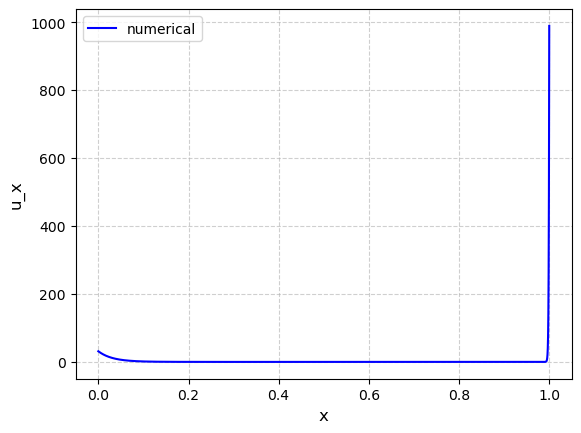

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import timeit

# 参数设置
epsilon = 0.001  # 摄动参数
N = 100000  # 划分的网格数
x = np.linspace(0, 1, N+1)  # x划分的网格点
h = 1.0 / N  # 网格间距

# 右端项函数f(x)
def f(x):
    return 0  # 这里将右端项设置为1

# 边界条件
u0, u1 = 1, 1

# 初始化矩阵和右端项F
main_diag = np.zeros(N-1)  # 主对角线元素
lower_diag = np.zeros(N-2)  # 下对角线元素
upper_diag = np.zeros(N-2)  # 上对角线元素
F = np.zeros(N-1)  # 右端项

# 填充三对角线和右端项F
a = timeit.default_timer()
for i in range(1, N):
    i_row = i - 1
    xi = x[i]
    
    # 有限差分离散化
    b_i = epsilon / h**2 + xi**2 / h   # u_{i-1} 的系数
    a_i = -2 * epsilon / h**2 - xi**2 / h - 1  # u_i 的系数
    c_i = epsilon / h**2  # u_{i+1} 的系数
    
    # 填充矩阵元素
    main_diag[i_row] = a_i
    if i > 1:
        lower_diag[i_row - 1] = b_i
    if i < N-1:
        upper_diag[i_row] = c_i
    
    # 右端项及边界条件处理
    F[i_row] = f(xi)
    # 左边界
    if i == 1:
        F[i_row] -= b_i * u0
    # 右边界
    if i == N-1:
        F[i_row] -= c_i * u1

# 构建并求解稀疏矩阵
A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format='csr')
U_internal = spsolve(A, F)

# 统计计算时长
b = timeit.default_timer() - a
print('Time for compute %.2f s' % (b))

# 合并边界值
U = np.zeros(N+1)
U[0] = u0
U[-1] = u1
U[1:-1] = U_internal

plt.plot(x, U, 'b-', linewidth=1.5, label='numerical')
plt.xlabel('x', fontsize=12)
plt.ylabel('u', fontsize=12)
plt.title(f'ε = {epsilon}, N = {N}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 计算残差
residual = np.zeros(N-1)
for i in range(1, N):
    xi = x[i]
    
    u_xx = (U[i+1] - 2*U[i] + U[i-1]) / h**2
    
    # 使用中心差分计算u_x
    if i == 1:  # 左边界
        u_x = (U[i+1] - U[i-1]) / (2 * h)
    elif i == N-1:  # 右边界
        u_x = (U[i] - U[i-2]) / (2 * h)
    else:  # 内部节点
        u_x = (U[i+1] - U[i-1]) / (2 * h)
    
    residual[i-1] = epsilon * u_xx - xi**2 * u_x - U[i]

print(f"修正后的最大残差：{np.max(np.abs(residual)):.2e}")

# 计算u_x并存储
u_x = np.zeros(N+1)  # 调整长度与x一致
for i in range(1, N):
    xi = x[i]
    coeff = xi**2
    
    if coeff > 0:
        u_x[i] = (U[i] - U[i-1]) / h  # 后向差分
    else:
        u_x[i] = (U[i+1] - U[i]) / h  # 前向差分

# 边界值处理
u_x[0] = (U[1] - U[0]) / h  # 左边界：前向差分
u_x[-1] = (U[-1] - U[-2]) / h  # 右边界：后向差分

# 对u_x取绝对值
u_x = abs(u_x)

plt.plot(x, u_x, 'b-', linewidth=1.5, label='numerical')
plt.xlabel('x', fontsize=12)
plt.ylabel('u_x', fontsize=12)
# plt.title(f'ε = {epsilon}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 存储数据(x,u)
np.savetxt('Example1--What.csv', np.column_stack((x, U, u_x)), delimiter=',')

#### 一维线性方程2: $\begin{cases}\varepsilon u_{xx} + (1-x)u_x - u = -cos(2\pi x), \ x\in (0,2)\\ u(0)=1 \, ,u(2)=-1 \\\end{cases}$

Time for compute 0.47 s


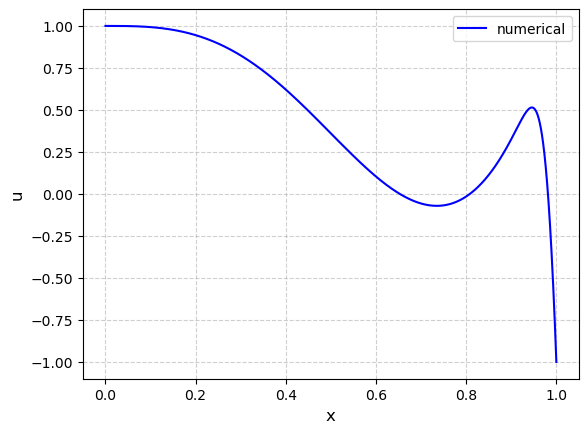

修正后的最大残差：3.49e-09


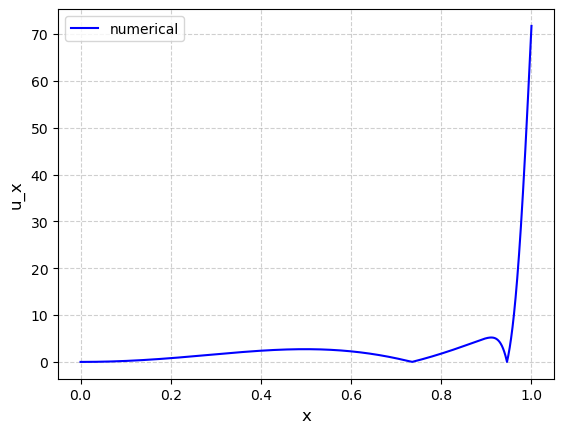

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import timeit

# 参数设置
epsilon = 1e-3
N = 100000  # 高网格数以应对小epsilon
x = np.linspace(0, 1, N+1)
h = 1.0 / N

# 新的右端项函数
def f(x):
    return -np.cos(2 * np.pi * x) #+ np.sin(2 * np.pi * x)

# 初始化矩阵和右端项
main_diag = np.zeros(N-1)
lower_diag = np.zeros(N-2)
upper_diag = np.zeros(N-2)
F = np.zeros(N-1)

# 填充三对角线和右端项F
a = timeit.default_timer()
for i in range(1, N):  # 内部节点i=1,2,...,N-1
    i_row = i - 1      # 矩阵行索引
    xi = x[i]
    coeff = (xi - 1)      # 对流项系数 (1 - x)
    
    # 迎风格式选择
    if coeff > 0:
        # 后向差分：u_x ≈ (u_i - u_{i-1})/h
        c_i = epsilon / h**2 - coeff / h
        a_i = (-2 * epsilon / h**2) + (coeff / h) 
        b_i = epsilon / h**2
    else:
        # 前向差分：u_x ≈ (u_{i+1} - u_i)/h
        c_i = epsilon / h**2
        a_i = (-2 * epsilon / h**2) - (coeff / h) - 1
        b_i = epsilon / h**2 + coeff / h
    
    # 填充矩阵元素
    main_diag[i_row] = a_i
    if i > 1:
        lower_diag[i_row - 1] = c_i
    if i < N-1:
        upper_diag[i_row] = b_i
    
    # 右端项及边界条件处理
    F[i_row] = f(xi)
    if i == 1:
        F[i_row] -= c_i * 1     # 左边界u(0)=1
    if i == N-1:
        F[i_row] -= b_i * (-1)  # 右边界u(2)=-1

# 构建并求解稀疏矩阵
A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format='csr')
U_internal = spsolve(A, F)

# 统计计算时长
b = timeit.default_timer() - a
print('Time for compute %.2f s' % (b))

# 合并边界值
U = np.zeros(N+1)
U[0] = 1
U[-1] = -1
U[1:-1] = U_internal

# 绘制数值解
# plt.figure(figsize=(10, 6))
plt.plot(x, U, 'b-', linewidth=1.5, label='numerical')

plt.xlabel('x', fontsize=12)
plt.ylabel('u', fontsize=12)
# plt.title(f'ε = {epsilon}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 计算残差
residual = np.zeros(N-1)
for i in range(1, N):
    xi = x[i]
    coeff = (xi - 1) 
    
    u_xx = (U[i+1] - 2*U[i] + U[i-1]) / h**2
    
    if coeff > 0:
        u_x = (U[i] - U[i-1]) / h # u_x ≈ (u_i - u_{i-1})/h
    else:
        u_x = (U[i+1] - U[i]) / h # u_x ≈ (u_{i+1} - u_i)/h
        
    residual[i-1] = epsilon * u_xx + coeff * u_x - U[i] - f(xi)

print(f"修正后的最大残差：{np.max(np.abs(residual)):.2e}")

# 计算u_x并存储
u_x = np.zeros(N+1)  # 调整长度与x一致
for i in range(1, N):
    xi = x[i]
    coeff = (xi - 1) 
    
    if coeff > 0:
        u_x[i] = (U[i] - U[i-1]) / h  # 后向差分
    else:
        u_x[i] = (U[i+1] - U[i]) / h  # 前向差分

# 边界值处理
u_x[0] = (U[1] - U[0]) / h  # 左边界：前向差分
u_x[-1] = (U[-1] - U[-2]) / h  # 右边界：后向差分

# 对u_x取绝对值
u_x = abs(u_x)

plt.plot(x, u_x, 'b-', linewidth=1.5, label='numerical')
plt.xlabel('x', fontsize=12)
plt.ylabel('u_x', fontsize=12)
# plt.title(f'ε = {epsilon}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()
u_x.shape, x.shape
# 存储数据(x,u)
np.savetxt('E2-1.csv', np.column_stack((x, U, u_x)), delimiter=',')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import timeit

# 参数设置
epsilon = 1e-9
N = 20000000  # 高网格数以应对小epsilon
x = np.linspace(0, 2, N+1)
h = 2.0 / N

# 新的右端项函数
def f(x):
    return -np.cos(2 * np.pi * x) #+ np.sin(2 * np.pi * x)

# 初始化矩阵和右端项
main_diag = np.zeros(N-1)
lower_diag = np.zeros(N-2)
upper_diag = np.zeros(N-2)
F = np.zeros(N-1)

# 填充三对角线和右端项F
a = timeit.default_timer()
for i in range(1, N):  # 内部节点i=1,2,...,N-1
    i_row = i - 1      # 矩阵行索引
    xi = x[i]
    coeff = -(xi - 1)      # 对流项系数 (1 - x)
    
    # 迎风格式选择
    if coeff > 0:
        # 后向差分：u_x ≈ (u_i - u_{i-1})/h
        c_i = epsilon / h**2 - coeff / h
        a_i = (-2 * epsilon / h**2) + (coeff / h) - 1
        b_i = epsilon / h**2
    else:
        # 前向差分：u_x ≈ (u_{i+1} - u_i)/h
        c_i = epsilon / h**2
        a_i = (-2 * epsilon / h**2) - (coeff / h) - 1
        b_i = epsilon / h**2 + coeff / h
    
    # 填充矩阵元素
    main_diag[i_row] = a_i
    if i > 1:
        lower_diag[i_row - 1] = c_i
    if i < N-1:
        upper_diag[i_row] = b_i
    
    # 右端项及边界条件处理
    F[i_row] = f(xi)
    if i == 1:
        F[i_row] -= c_i * 1     # 左边界u(0)=1
    if i == N-1:
        F[i_row] -= b_i * (-1)  # 右边界u(2)=-1

# 构建并求解稀疏矩阵
A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format='csr')
U_internal = spsolve(A, F)

# 统计计算时长
b = timeit.default_timer() - a
print('Time for compute %.2f s' % (b))

# 合并边界值
U = np.zeros(N+1)
U[0] = 1
U[-1] = -1
U[1:-1] = U_internal

# 绘制数值解
# plt.figure(figsize=(10, 6))
plt.plot(x, U, 'b-', linewidth=1.5, label='numerical')

# plt.xlabel('x', fontsize=12)
# plt.ylabel('u', fontsize=12)
# plt.title(f'ε = {epsilon}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# 计算残差
residual = np.zeros(N-1)
for i in range(1, N):
    xi = x[i]
    coeff = -(xi - 1) 
    
    u_xx = (U[i+1] - 2*U[i] + U[i-1]) / h**2
    
    if coeff > 0:
        u_x = (U[i] - U[i-1]) / h # u_x ≈ (u_i - u_{i-1})/h
    else:
        u_x = (U[i+1] - U[i]) / h # u_x ≈ (u_{i+1} - u_i)/h
        
    residual[i-1] = epsilon * u_xx + coeff * u_x - U[i] - f(xi)

print(f"修正后的最大残差：{np.max(np.abs(residual)):.2e}")

# 计算u_x并存储
u_x = np.zeros(N+1)  # 调整长度与x一致
for i in range(1, N):
    xi = x[i]
    coeff = -(xi - 1)
    
    if coeff > 0:
        u_x[i] = (U[i] - U[i-1]) / h  # 后向差分
    else:
        u_x[i] = (U[i+1] - U[i]) / h  # 前向差分

# 边界值处理
u_x[0] = (U[1] - U[0]) / h  # 左边界：前向差分
u_x[-1] = (U[-1] - U[-2]) / h  # 右边界：后向差分

# 对u_x取绝对值
u_x = abs(u_x)

plt.plot(x, u_x, 'b-', linewidth=1.5, label='numerical')
# plt.xlabel('x', fontsize=12)
# plt.ylabel('u_x', fontsize=12)
# plt.title(f'ε = {epsilon}', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()
u_x.shape, x.shape
# 存储数据(x,u)
# np.savetxt('E2--[-9].csv', np.column_stack((x, U, u_x)), delimiter=',')

RuntimeError: SUPERLU_MALLOC fails for buf in intCalloc() at line 172 in file ../scipy/sparse/linalg/_dsolve/SuperLU/SRC/memory.c


#### 一维非线性方程1: $\begin{cases}\varepsilon u_{xx} + uu_x - u = 0, \ x\in (0,1)\\ u(0)=-1 \, ,u(1)=1 \\\end{cases}$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import timeit

# 参数设置
epsilon = 1e-3
N = 200000 # 高网格数以应对小epsilon
x = np.linspace(0, 1, N + 1)
h = 1.0 / N
# 左、右边界值
A = -1
B = 1

# 新的右端项函数
def f(x):
    return 0

# 选择一个满足边界条件的初始猜测值u0
u_initial = np.zeros(N + 1)
u_initial[0] = A
u_initial[-1] = B
# 由此，我们猜测u0 = 2x - 1
u_initial[1:-1] = 2 * x[1:-1] - 1
u_current = u_initial[1:-1].copy()

# 迭代求解
max_iter = 2000 # 最大迭代次数
tol = 1e-6 # 收敛容差

a = timeit.default_timer()
for iter in range(max_iter):
    
    # 计算残差F
    F = np.zeros(N - 1)
    
    for i in range(1, N):
        u_i = u_current[i - 1]
        
        # 考虑边界条件
        if i == 1:
            u_prev = A
        else:
            u_prev = u_current[i - 2]
            
        if i == N - 1:
            u_next = B
        else:
            u_next = u_current[i]
            
        # 扩散项：中心差分
        diffusion = epsilon * (u_next - 2 * u_i + u_prev) / h**2

        # 非线性项：迎风格式
        if u_i > 0:
            convection = u_i * (u_i - u_prev) / h
        else:
            convection = u_i * (u_next - u_i) / h
            
        # 残差计算
        F[i - 1] = diffusion + convection - u_i ** 2 - f(x[i])
        
    # 检查收敛性
    residual_norm = np.max(np.abs(F))
    print(f"Iteration {iter:2d}: Residual norm = {residual_norm:.4e}")
    if residual_norm < tol:
        print("Converged!")
        break
    
    # 构造雅可比矩阵
    main_diag = np.zeros(N - 1)
    lower_diag = np.zeros(N - 2)
    upper_diag = np.zeros(N - 2)
    
    for i in range(1, N):
        i_row = i - 1
        u_i = u_current[i - 1]
        
        # 扩散项贡献
        main_diag[i_row] = -2 * epsilon / h**2
        if i > 1:
            lower_diag[i_row - 1] = epsilon / h**2
        if i < N - 1:
            upper_diag[i_row] = epsilon / h**2
            
        # 对流项贡献
        if u_i > 0: # 使用后向差分
             
            if i == 1:
                u_prev = A
            else:
                u_prev = u_current[i - 2]
            
            main_diag[i_row] += (2 * u_i - u_prev) / h
            if i > 1:
                lower_diag[i_row - 1] += -u_i / h
        
        else: # 使用前向差分
            if i == N - 1:
                u_next = B
            else:
                u_next = u_current[i]
            
            main_diag[i_row] += (u_next - 2 * u_i) / h
            if i < N - 1:
                upper_diag[i_row] += u_i / h
         
        # -u项贡献
        main_diag[i_row] += -2 * u_i
    
    # 构建稀疏矩阵并求解
    J = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format="csr")
    delta_u = spsolve(J, -F)
    u_current += delta_u

# 统计计算时长
b = timeit.default_timer() - a
print('Time for compute %.2f s' % (b))

# 合并边界得到最终解
u_final = np.zeros(N + 1)
u_final[0] = A
u_final[-1] = B
u_final[1:-1] = u_current

# 绘制数值解
# plt.figure(figsize=(10, 6))
plt.plot(x, u_final, "b-", linewidth=1.5, label="Numerical")
plt.xlabel("x", fontsize=12)
plt.ylabel("u", fontsize=12)
# plt.title(f"Solution for ε = {epsilon}", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# 存储数据(x,u)
# np.savetxt("Example2-1,-1.csv", np.column_stack((x, u_final)), delimiter=",")

Iteration  0: Residual norm = 3.0000e+00
Iteration  1: Residual norm = 5.9152e+08
Iteration  2: Residual norm = 1.1185e+38
Iteration  3: Residual norm = 1.9921e+40
Iteration  4: Residual norm = 4.9804e+39
Iteration  5: Residual norm = 1.5065e+40
Iteration  6: Residual norm = 3.7662e+39
Iteration  7: Residual norm = 1.5657e+39
Iteration  8: Residual norm = 3.9143e+38
Iteration  9: Residual norm = 3.3360e+43
Iteration 10: Residual norm = 8.3401e+42
Iteration 11: Residual norm = 2.0850e+42
Iteration 12: Residual norm = 5.2126e+41
Iteration 13: Residual norm = 7.7872e+48
Iteration 14: Residual norm = 1.9468e+48
Iteration 15: Residual norm = 4.8670e+47
Iteration 16: Residual norm = 1.2168e+47
Iteration 17: Residual norm = 3.0419e+46
Iteration 18: Residual norm = 7.6047e+45
Iteration 19: Residual norm = 1.9012e+45
Iteration 20: Residual norm = 4.7529e+44
Iteration 21: Residual norm = 1.1882e+44
Iteration 22: Residual norm = 2.9706e+43
Iteration 23: Residual norm = 7.4265e+42
Iteration 24: Re

Iteration  0: Residual norm = 9.9999e-01
Iteration  1: Residual norm = 3.0795e+01
Iteration  2: Residual norm = 7.5222e+00
Iteration  3: Residual norm = 9.6470e-01
Iteration  4: Residual norm = 2.2247e-02
Iteration  5: Residual norm = 1.1503e-05
Iteration  6: Residual norm = 8.7306e-09
Converged!
Time for compute 5.30 s


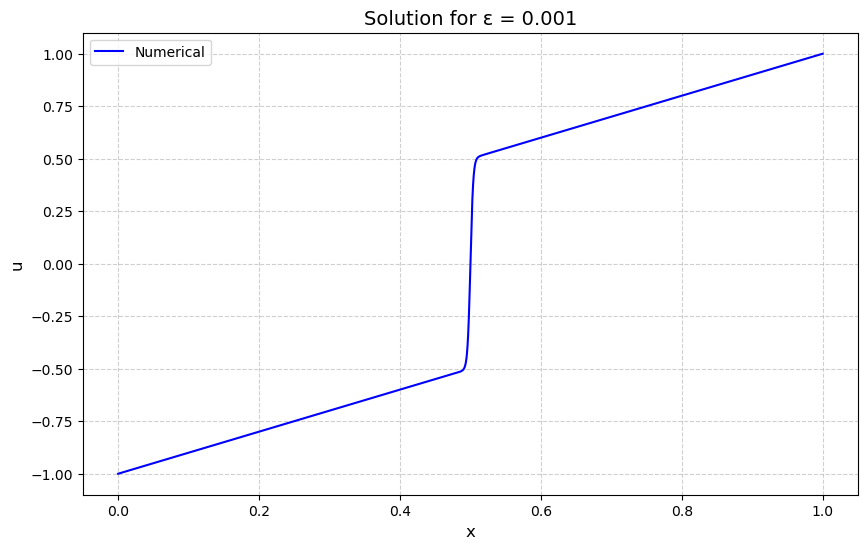

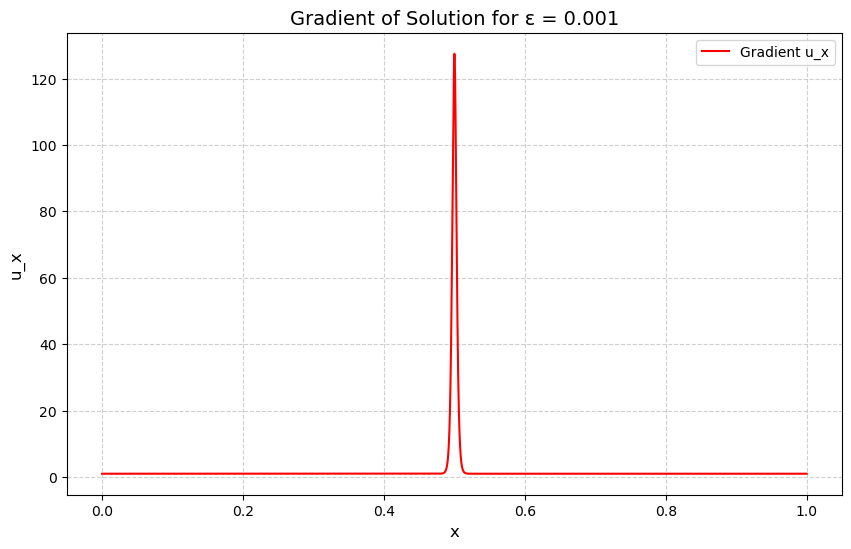

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import timeit

# 参数设置
epsilon = 1e-3
N = 200000  # 高网格数以应对小epsilon
x = np.linspace(0, 1, N + 1)
h = 1.0 / N
# 左、右边界值
A = -1
B = 1

# 新的右端项函数
def f(x):
    return 0

# 选择一个满足边界条件的初始猜测值u0
u_initial = np.zeros(N + 1)
u_initial[0] = A
u_initial[-1] = B
# 由此，我们猜测u0 = 2x - 1
u_initial[1:-1] = 2 * x[1:-1] - 1
u_current = u_initial[1:-1].copy()

# 迭代求解
max_iter = 2000  # 最大迭代次数
tol = 1e-8  # 收敛容差

a = timeit.default_timer()
for iter in range(max_iter):
    
    # 计算残差F
    F = np.zeros(N - 1)
    
    for i in range(1, N):
        u_i = u_current[i - 1]
        
        # 考虑边界条件
        if i == 1:
            u_prev = A
        else:
            u_prev = u_current[i - 2]
            
        if i == N - 1:
            u_next = B
        else:
            u_next = u_current[i]
            
        # 扩散项：中心差分
        diffusion = epsilon * (u_next - 2 * u_i + u_prev) / h**2

        # 非线性项：迎风格式
        if u_i > 0:
            convection = u_i * (u_i - u_prev) / h
        else:
            convection = u_i * (u_next - u_i) / h
            
        # 残差计算
        F[i - 1] = diffusion + convection - u_i - f(x[i])
        
    # 检查收敛性
    residual_norm = np.max(np.abs(F))
    print(f"Iteration {iter:2d}: Residual norm = {residual_norm:.4e}")
    if residual_norm < tol:
        print("Converged!")
        break
    
    # 构造雅可比矩阵
    main_diag = np.zeros(N - 1)
    lower_diag = np.zeros(N - 2)
    upper_diag = np.zeros(N - 2)
    
    for i in range(1, N):
        i_row = i - 1
        u_i = u_current[i - 1]
        
        # 扩散项贡献
        main_diag[i_row] = -2 * epsilon / h**2
        if i > 1:
            lower_diag[i_row - 1] = epsilon / h**2
        if i < N - 1:
            upper_diag[i_row] = epsilon / h**2
            
        # 对流项贡献
        if u_i > 0:  # 使用后向差分
            if i == 1:
                u_prev = A
            else:
                u_prev = u_current[i - 2]
            
            main_diag[i_row] += (2 * u_i - u_prev) / h
            if i > 1:
                lower_diag[i_row - 1] += -u_i / h
        
        else:  # 使用前向差分
            if i == N - 1:
                u_next = B
            else:
                u_next = u_current[i]
            
            main_diag[i_row] += (u_next - 2 * u_i) / h
            if i < N - 1:
                upper_diag[i_row] += u_i / h
         
        # -u项贡献
        main_diag[i_row] += -1

    # 构建稀疏矩阵并求解
    J = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], format="csr")
    delta_u = spsolve(J, -F)
    u_current += delta_u

# 统计计算时长
b = timeit.default_timer() - a
print('Time for compute %.2f s' % (b))

# 合并边界得到最终解
u_final = np.zeros(N + 1)
u_final[0] = A
u_final[-1] = B
u_final[1:-1] = u_current

# 绘制数值解
plt.figure(figsize=(10, 6))
plt.plot(x, u_final, "b-", linewidth=1.5, label="Numerical")
plt.xlabel("x", fontsize=12)
plt.ylabel("u", fontsize=12)
plt.title(f"Solution for ε = {epsilon}", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# 计算梯度 u_x
u_x = np.zeros(N + 1)

# 使用中心差分法计算中间点的梯度
for i in range(1, N):
    u_x[i] = (u_final[i + 1] - u_final[i - 1]) / (2 * h)

# 对边界点使用前向和后向差分法
u_x[0] = (u_final[1] - u_final[0]) / h
u_x[-1] = (u_final[-1] - u_final[-2]) / h

# 绘制数值解的梯度图
plt.figure(figsize=(10, 6))
plt.plot(x, u_x, "r-", linewidth=1.5, label="Gradient u_x")
plt.xlabel("x", fontsize=12)
plt.ylabel("u_x", fontsize=12)
plt.title(f"Gradient of Solution for ε = {epsilon}", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# 存储数据(x,u)
np.savetxt('E4--[-3].csv', np.column_stack((x, u_final, u_x)), delimiter=',')

# 偏微分方程

#### 二维线性方程

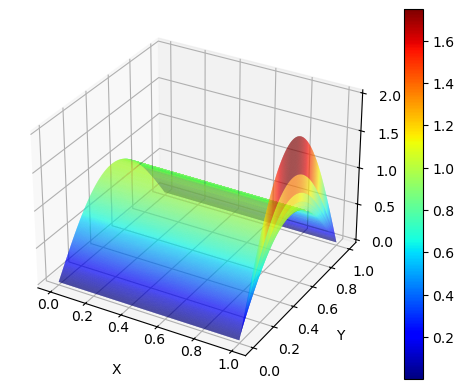

((1001,), (1001,), (1001, 1001))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import timeit
def solve_pde(epsilon, Nx, Ny, f=None):
    dx = 1.0 / (Nx + 1)
    dy = 1.0 / (Ny + 1)
    
    x = np.linspace(0, 1, Nx + 2)
    y = np.linspace(0, 1, Ny + 2)
    
    # 初始化矩阵和右侧向量
    A = lil_matrix((Nx * Ny, Nx * Ny))
    b = np.zeros(Nx * Ny)
    
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            k = (i - 1) * Ny + (j - 1)
            b_k = 0.0
            
            # 自身系数
            A[k, k] = 2 * epsilon / dx**2 + 2 * epsilon / dy**2 + 1/dx
            
            # 右侧节点 (i+1, j)
            if i < Nx:
                A[k, k + Ny] = -epsilon / dx**2
            else:
                # 右边界条件 u=2*sin(πy)
                y_val = y[j]
                b_k += epsilon / dx**2 * 2 * np.sin(np.pi * y_val)
            
            # 左侧节点 (i-1, j)
            if i > 1:
                A[k, k - Ny] = -epsilon / dx**2 - 1/dx
            else:
                # 左边界条件 u=sin(πy)
                y_val = y[j]
                b_k += (epsilon / dx**2 + 1/dx) * np.sin(np.pi * y_val)
            
            # 上方节点 (i, j+1)
            if j < Ny:
                A[k, k + 1] = -epsilon / dy**2
            
            # 下方节点 (i, j-1)
            if j > 1:
                A[k, k - 1] = -epsilon / dy**2
            
            # 添加右端项 f(x, y)
            if f is not None:
                x_val = x[i]
                y_val = y[j]
                b_k += f(x_val, y_val)
            
            b[k] = b_k
    
    # 转换矩阵格式并求解
    A = A.tocsr()
    u = spsolve(A, b)
    
    # 构建包含边界的解矩阵
    u_total = np.zeros((Nx + 2, Ny + 2))
    u_total[1:-1, 1:-1] = u.reshape(Nx, Ny)
    
    # 填充边界
    u_total[:, 0] = 0
    u_total[:, -1] = 0
    for j in range(Ny + 2):
        y_val = y[j]
        u_total[0, j] = np.sin(np.pi * y_val)
        u_total[-1, j] = 2 * np.sin(np.pi * y_val)
    
    return x, y, u_total

# 参数设置
epsilon = 0.001
Nx = 999
Ny = 999

# 定义右端项函数
def f(x, y):
    return 0.0

# 求解偏微分方程
x, y, u = solve_pde(epsilon, Nx, Ny, f=f)

# 可视化
X, Y = np.meshgrid(x, y, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, u, cmap='jet', rstride=1, cstride=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('U')
ax.tick_params(axis='z', pad=4)
ax.tick_params(axis='x', pad=-5)
ax.tick_params(axis='y', pad=2)
ax.locator_params(axis='z', nbins=5)
# plt.title('Solution of the Convection-Diffusion Equation')
fig.colorbar(surf, ax=ax)
plt.show()

# 存储数据(x,y,u)
# data = np.column_stack((X.flatten(), Y.flatten(), u.flatten()))
# np.savetxt("abab.csv", data, delimiter=",", header="x, y, u", comments="")
x.shape, y.shape, u.shape

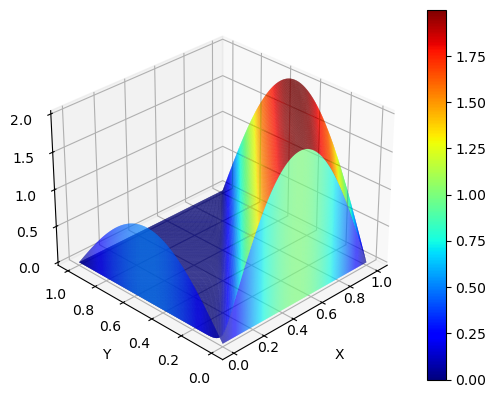

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import timeit
def solve_pde(epsilon, Nx, Ny, f=None):
    dx = 1.0 / (Nx + 1)
    dy = 1.0 / (Ny + 1)
    
    x = np.linspace(0, 1, Nx + 2)
    y = np.linspace(0, 1, Ny + 2)
    
    # 初始化矩阵和右侧向量
    A = lil_matrix((Nx * Ny, Nx * Ny))
    b = np.zeros(Nx * Ny)
    
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            k = (i - 1) * Ny + (j - 1)
            b_k = 0.0

            x_val = x[i]
            y_val = y[j]
            
            # 自身系数
            A[k, k] = -2 * epsilon / dx**2 - 2 * epsilon / dy**2 + 1/dx + 1/dy
            
            # 右侧节点 (i+1, j)
            if i < Nx:
                A[k, k + Ny] = epsilon / dx**2
            else:
                # 右边界条件 u=2*sin(πy)
                b_k += -epsilon / dx**2 * 2 * np.sin(np.pi * y_val)
            
            # 左侧节点 (i-1, j)
            if i > 1:
                A[k, k - Ny] = epsilon / dx**2 - 1/dx 
            else:
                # 左边界条件 u=sin(πy)
                b_k += (-epsilon / dx**2 + 1/dx) * np.sin(np.pi * y_val)
            
            # 上方节点 (i, j+1)
            if j < Ny:
                A[k, k + 1] = epsilon / dy**2
            
            # 下方节点 (i, j-1)
            if j > 1:
                A[k, k - 1] = epsilon / dy**2 - 1/dy
            
            # 添加右端项 f(x, y)
            if f is not None:
                b_k += f(x_val, y_val)
            
            b[k] = b_k
    
    # 转换矩阵格式并求解
    A = A.tocsr()
    u = spsolve(A, b)
    
    # 构建包含边界的解矩阵
    u_total = np.zeros((Nx + 2, Ny + 2))
    u_total[1:-1, 1:-1] = u.reshape(Nx, Ny)
    
    # 填充边界
    u_total[:, 0] = 0
    u_total[:, -1] = 0
    for j in range(Ny + 2):
        y_val = y[j]
        u_total[0, j] = np.sin(np.pi * y_val)
        u_total[-1, j] = 2 * np.sin(np.pi * y_val)
    
    return x, y, u_total

# 参数设置
epsilon = 0.001
Nx = 999
Ny = 999

# 定义右端项函数
def f(x, y):
    return 0.0

# 求解偏微分方程
x, y, u = solve_pde(epsilon, Nx, Ny, f=f)

# 可视化
X, Y = np.meshgrid(x, y, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, u, cmap='jet', rstride=1, cstride=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('U')
ax.view_init(elev=30, azim=-135)
ax.tick_params(axis='z', pad=4)
ax.tick_params(axis='x', pad=-5)
ax.tick_params(axis='y', pad=2)
ax.locator_params(axis='z', nbins=5)
# plt.title('Solution of the Convection-Diffusion Equation')
fig.colorbar(surf, ax=ax)
plt.show()

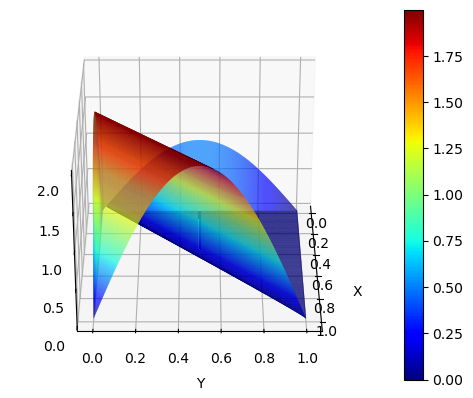

In [9]:
# X, Y = np.meshgrid(x, y, indexing='ij')
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(X, Y, u, cmap='jet', rstride=1, cstride=1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# fig.colorbar(surf, ax=ax)
# plt.show()

# fig, ax1 = plt.subplots()

# # 绘制 QuadMesh 图形
# quad1 = ax1.pcolormesh(X, Y, u, cmap='jet', edgecolor='none')
# ax.view_init(elev=30, azim=-135)
# # 创建颜色条
# cbar = fig.colorbar(quad1, ax=ax1)
# plt.show()
X, Y = np.meshgrid(x, y, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, u, cmap='jet', rstride=1, cstride=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('U')
ax.view_init(elev=30, azim=0)
ax.tick_params(axis='z', pad=4)
ax.tick_params(axis='x', pad=-5)
ax.tick_params(axis='y', pad=2)
ax.locator_params(axis='z', nbins=5)
# plt.title('Solution of the Convection-Diffusion Equation')
fig.colorbar(surf, ax=ax)
plt.show()

[-12.56636545   0.           0.         ...   0.           0.
  -6.28318272]


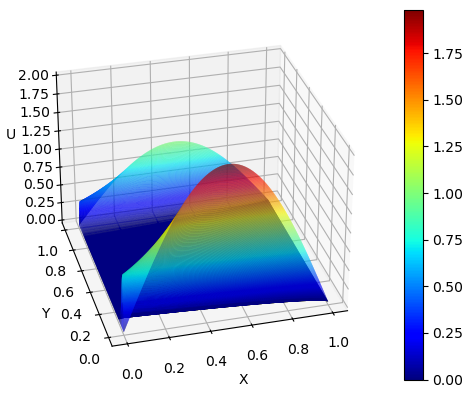

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

def solve_pde(epsilon, Nx, Ny, f=None):
    dx = 1.0 / (Nx + 1)
    dy = 1.0 / (Ny + 1)
    
    x = np.linspace(0, 1, Nx + 2)
    y = np.linspace(0, 1, Ny + 2)
    
    # 初始化矩阵和右侧向量
    A = lil_matrix((Nx * Ny, Nx * Ny))
    b = np.zeros(Nx * Ny)
    
    for i in range(1, Nx + 1):
        for j in range(1, Ny + 1):
            k = (i - 1) * Ny + (j - 1)
            b_k = 0.0

            x_val = x[i]
            y_val = y[j]
            
            # 自身系数
            A[k, k] = -2 * epsilon / dx**2 - 2 * epsilon / dy**2 + 1/dx 
            
            # 右侧节点 (i+1, j)
            if i < Nx:
                A[k, k + Ny] = epsilon / dx**2
            else:
                # 右边界条件 u=0
                b_k += -epsilon / dx**2 * 0.0
            
            # 左侧节点 (i-1, j)
            if i > 1:
                A[k, k - Ny] = epsilon / dx**2 - 1/dx 
            else:
                # 左边界条件 u=0
                b_k += (-epsilon / dx**2 + 1/dx) * 0.0
            
            # 上方节点 (i, j+1)
            if j < Ny:
                A[k, k + 1] = epsilon / dy**2
            else:
                # 上边界条件 u=2*sin(πx)
                b_k += -(epsilon / dy**2) * 1 * np.sin(np.pi * x_val)
            
            # 下方节点 (i, j-1)
            if j > 1:
                A[k, k - 1] = epsilon / dy**2 
            else:
                # 下边界条件 u=sin(πx)
                b_k += -(epsilon / dy**2) * 2 * np.sin(np.pi * x_val)
            
            # 添加右端项 f(x, y)
            if f is not None:
                b_k += f(x_val, y_val)
            
            b[k] = b_k
    
    # 转换矩阵格式并求解
    A = A.tocsr()
    u = spsolve(A, b)
    
    # 构建包含边界的解矩阵
    u_total = np.zeros((Nx + 2, Ny + 2))
    u_total[1:-1, 1:-1] = u.reshape(Nx, Ny)
    
    # 填充边界
    u_total[:, 0] = 2 * np.sin(np.pi * x)       # 下边界 y=0
    u_total[:, -1] = 1 * np.sin(np.pi * x)  # 上边界 y=1
    u_total[0, :] = 0                       # 左边界 x=0
    u_total[-1, :] = 0                      # 右边界 x=1
    
    return x, y, u_total, b

# 参数设置
epsilon = 0.001
Nx = 1999
Ny = 1999

# 定义右端项函数
def f(x, y):
    return 0.0

# 求解偏微分方程
x, y, u, b = solve_pde(epsilon, Nx, Ny, f=f)
print(b)
# 可视化
X, Y = np.meshgrid(x, y, indexing='ij')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, u, cmap='jet', rstride=1, cstride=1)
ax.view_init(elev=30,azim=-105)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
fig.colorbar(surf, ax=ax)
plt.show()

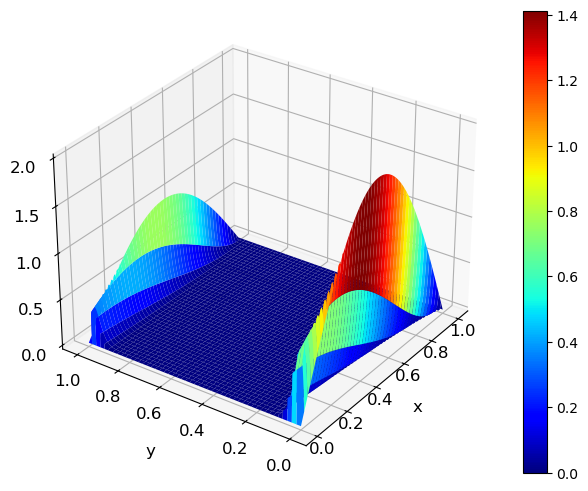

In [2]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': '3d'})

# 绘制3D曲面图
surf = ax.plot_surface(X, Y, u, cmap='jet', edgecolor='none')
norm = mcolors.Normalize(vmin=u.min(), vmax=u.max())
fig.colorbar(surf, norm=norm)
# 设置坐标轴标签
ax.set_xlabel('x', labelpad=-2, fontsize=12)
ax.set_ylabel('y', labelpad=8, fontsize=12)
# ax.set_zlabel('u', labelpad=6, fontsize=12)

# 设置视角
ax.view_init(elev=30, azim=-145)

# 设置坐标轴刻度参数
ax.tick_params(axis='z', pad=4)
ax.tick_params(axis='x', pad=-5)
ax.tick_params(axis='y', pad=2)
ax.tick_params(which='major', labelsize=12)
ax.locator_params(axis='z', nbins=5)
plt.show()
X_flat = X.flatten()
Y_flat = Y.flatten()
u_flat = u.flatten()

# 使用 np.column_stack
data = np.column_stack((X_flat, Y_flat, u_flat))

# np.savetxt("E3-32.csv", data, delimiter=",", header="x, y, u", comments="")

#### 一维线性含时方程

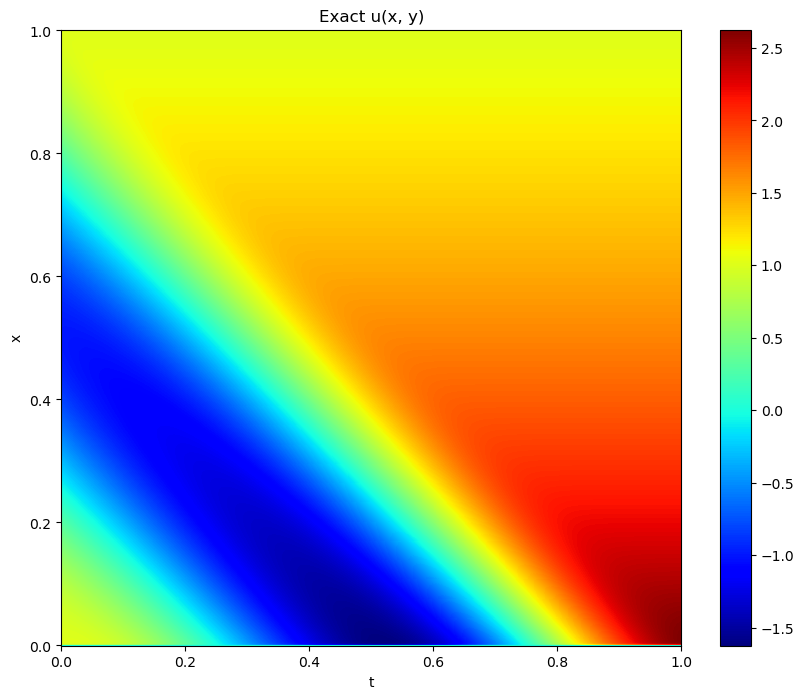

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.sparse import diags
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import timeit

# 参数设置
epsilon = 0.001
L = 1.0
T = 1.0
Nx = 1200
Nt = 6000
dx = L / Nx
dt = T / Nt

x = np.linspace(0, L + dx, Nx)
t = np.linspace(0, T + dt, Nt+1)

X, T = np.meshgrid(x, t)
# 初始化解数组
u = np.zeros((Nt + 1, Nx))
u[0, :] = np.cos(2 * np.pi * X[0, :]) # 初始条件

# 时间步进
for n in range(Nt):
    for i in range(1, Nx - 1):
        # 计算对流项 u_x
        u_x = (u[n, i + 1] - u[n, i - 1]) / (2 * dx)
        # 计算扩散项 u_xx
        u_xx = (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1]) / (dx**2)
        # 更新下一个时间步的值
        u[n + 1, i] = u[n, i] + dt * (epsilon * u_xx + u_x + u[n, i])
    
    # 更新边界条件
    u[n + 1, 0] = 0  # 左边界
    u[n + 1, -1] = 1  # 右边界

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
surf = ax.pcolormesh(T, X, u, cmap='jet', edgecolor='none')
norm = mcolors.Normalize(vmin=u.min(), vmax=u.max())
fig.colorbar(surf, norm=norm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Exact u(x, y)')
plt.show()

# 存储数据(x,t,u)
# data = np.column_stack((X.flatten(), T.flatten(), u.flatten()))
# np.savetxt("bcbc.csv", data, delimiter=",", header="x, t, u", comments="")

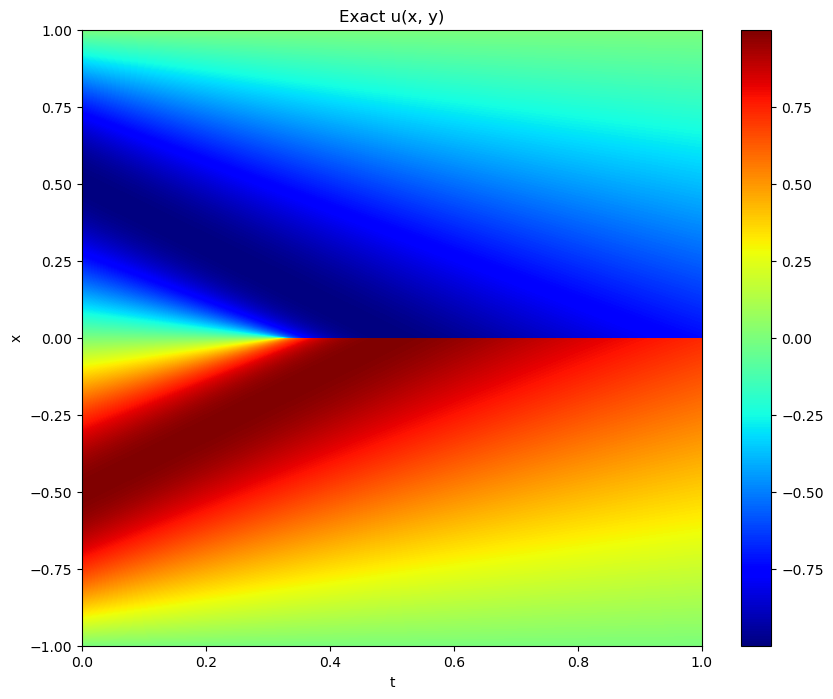

(10000, 12800)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 参数设置
nu = 0.0001   # 扩散系数
L = 2.0            # 空间范围 [-1, 1]
dx = 1 / 6400         # 空间步长
Nx = int(L / dx)            # 空间网格数
x = np.linspace(-1, 1, Nx )  # 空间网格点

T = 1.0            # 总时间
dt = 0.0001         # 时间步长
Nt = int(T / dt)  # 时间步数

t = np.linspace(0, T, Nt )  # 时间网格点
X, T = np.meshgrid(x, t)  # 生成网格

# 初始条件
u = -np.sin(np.pi * x)
u[0] = u[-1] = 0.0  # 应用边界条件

# 存储解以绘制3D结果
u_all = np.zeros((Nt , Nx ))  # 初始化存储数组
u_all[0, :] = u.copy()  # 保存初始条件

# 时间迭代
for n in range(Nt-1):
    u_prev = u.copy()
    # 计算内部点的导数（使用中心差分）
    u_x = (u_prev[2:] - u_prev[:-2]) / (2 * dx)          # 对流项一阶导数
    u_xx = (u_prev[2:] - 2 * u_prev[1:-1] + u_prev[:-2]) / dx**2  # 扩散项二阶导数
    # 更新内部点
    u[1:-1] = u_prev[1:-1] + dt * (-u_prev[1:-1] * u_x + nu * u_xx)
    # 强制边界条件
    u[0], u[-1] = 0.0, 0.0
    u_all[n+1, :] = u.copy()

# 绘制3D结果
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
surf = ax.pcolormesh(T, X, u_all, cmap='jet', edgecolor='none')
norm = mcolors.Normalize(vmin=u_all.min(), vmax=u_all.max())
fig.colorbar(surf, norm=norm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Exact u(x, y)')
plt.show()

# 存储数据(x,t,u)
# data = np.column_stack((X.flatten(), T.flatten(), u_all.flatten()))
# np.savetxt("burgers-2.csv", data, delimiter=",", header="x, t, u", comments="")

u_all.shape

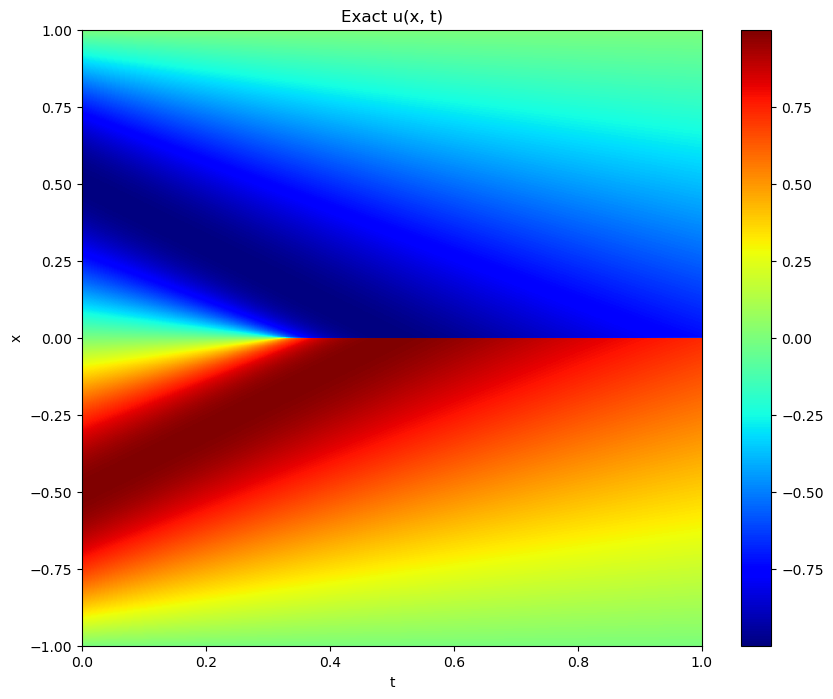

array([-1.        , -0.99921869, -0.99843738, ...,  0.99828112,
        0.99906243,  1.        ])

In [2]:
import scipy.io as sio
time_indices = np.linspace(0, Nt-1, 1000, dtype=int)  # 选择100个时间点
t_reduced = t[time_indices]

# 空间步数平分为 256 份
space_indices = np.linspace(0, Nx-1, 2560, dtype=int)  # 选择256个空间点
x_reduced = x[space_indices]

# 提取降采样后的网格点和解
X_reduced, T_reduced = np.meshgrid(x_reduced, t_reduced)  # 注意：这里X和T的维度与原网格不同，需重新生成
u_reduced = u_all[time_indices, :][:, space_indices] 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
surf = ax.pcolormesh(T_reduced, X_reduced, u_reduced, cmap='jet', edgecolor='none')
norm = mcolors.Normalize(vmin=u_all.min(), vmax=u_all.max())
fig.colorbar(surf, norm=norm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Exact u(x, t)')
plt.show()

data_dict = {
    'x': x_reduced,
    't': t_reduced,
    'u': u_reduced
}

sio.savemat('burgers-4.mat', data_dict)
u_reduced.shape, T_reduced.shape, X_reduced.shape
x_reduced

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 参数设置
epsilon = 0.0001  # 扩散系数
L = 2.0            # 空间范围 [-1, 1]
dx = 0.0005        # 空间步长
Nx = int(L / dx)            # 空间网格数
x = np.linspace(-1, 1, Nx)  # 空间网格点

T = 1.0            # 总时间
dt = 0.00001         # 时间步长
Nt = int(T / dt)  # 时间步数

t = np.linspace(0, T, Nt + 1)  # 时间网格点
X, T = np.meshgrid(x, t)  # 生成网格

# 初始化解数组
u = np.zeros((Nt + 1, Nx))
u[0, :] = -np.sin(np.pi * X[0, :]) # 初始条件

# 时间迭代
for n in range(Nt):
    for i in range(1, Nx - 1):
        # 计算内部点的导数（使用中心差分）
        u_x = (u[n, i + 1] - u[n, i - 1]) / (2 * dx)
        # 计算扩散项 u_xx
        u_xx = (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1]) / (dx**2)
        # 更新内部点
        u[n + 1, i] = u[n, i] + dt * (epsilon * u_xx - u[n, i] * u_x )
    
    # 更新边界条件
    u[n + 1, 0] = 0  # 左边界
    u[n + 1, -1] = 0  # 右边界

# 绘制3D结果
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
surf = ax.pcolormesh(T, X, u, cmap='jet', edgecolor='none')
norm = mcolors.Normalize(vmin=u.min(), vmax=u.max())
fig.colorbar(surf, norm=norm)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Exact u(x, y)')
plt.show()

In [ ]:
import numpy as np

def self_scaled_broyden(F, x0, tol=1e-6, max_iter=1000):
    x = np.array(x0, dtype=float)
    n = len(x)
    B = np.eye(n)
    alpha = 1.0  # 初始步长

    for k in range(max_iter):
        Fx = F(x)
        if np.linalg.norm(Fx) < tol:
            return x  # 收敛条件满足

        p = -np.linalg.solve(B, Fx)
        x_new = x + alpha * p
        y = F(x_new) - Fx
        s = x_new - x

        # 检查 np.dot(s, y) 是否接近零
        dot_product = np.dot(s, y)
        if abs(dot_product) < 1e-10:
            alpha *= 0.5  # 如果接近零，减小步长
            continue   #过当前迭代

        # 计算 rho
        rho = 1.0 / dot_product

        # 更新近似矩阵
        V = np.eye(len(s)) - rho * np.outer(s, y)
        B = np.dot(np.dot(V.T, B), V) + rho * np.outer(s, s)

        x = x_new

    raise ValueError("Failed to converge within the maximum number of iterations")

def self_scaled_broyden_update(B, s, y):
    dot_product = np.dot(s, y)
    if abs(dot_product) < 1e-10:
        raise ValueError("Dot product of s and y is too small, causing numerical instability.")
    rho = 1.0 / dot_product
    V = np.eye(len(s)) - rho * np.outer(s, y)
    B_new = np.dot(np.dot(V.T, B), V) + rho * np.outer(s, s)
    return B_new

# 示例函数
def F(x):
    return np.array([x[0]**3 - 2*x[0]**2 + 3*x[0] - 5, np.sin(x[1]) - 0.5*x[1]])

x0 = [0.0, 0.0]
try:
    solution = self_scaled_broyden(F, x0)
    print("Solution:", solution)
except ValueError as e:
    print(e)

Failed to converge within the maximum number of iterations


C:\Users\31884\AppData\Local\Temp\ipykernel_25404\2543378084.py:29: RuntimeWarning: invalid value encountered in multiply
  V = np.eye(len(s)) - rho * np.outer(s, y)


In [ ]:
import numpy as np

def wolfe_line_search(f, grad_f, x, d, alpha0=100, c1=1e-4, c2=0.9):
    """
    Wolfe条件的线搜索
    :param f: 目标函数
    :param grad_f: 目标函数的梯度
    :param x: 当前点
    :param d: 搜索方向
    :param alpha0: 初始步长
    :param c1: Armijo条件中的常数
    :param c2: 曲率条件中的常数
    :return: 满足Wolfe条件的步长
    """
    alpha = alpha0
    while True:
        if f(x + alpha * d) > f(x) + c1 * alpha * np.dot(grad_f(x), d):
            alpha *= 0.5  # 如果不满足Armijo条件，减小步长
        elif np.dot(grad_f(x + alpha * d), d) < c2 * np.dot(grad_f(x), d):
            alpha *= 2  # 如果不满足曲率条件，增大步长
        else:
            break  # 满足Wolfe条件
    return alpha

# 示例目标函数和梯度
def f(x):
    return x[0]**2 + x[1]**2

def grad_f(x):
    return np.array([2*x[0], 2*x[1]])

# 当前点和搜索方向
x = np.array([1.0, 1.0])
d = np.array([-1.0, -1.0])

# 执行线搜索
alpha = wolfe_line_search(f, grad_f, x, d)
print("Step size:", alpha)

Step size: 1.5625


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csc_matrix, linalg
from scipy.sparse.linalg import spsolve
from time import time

# 参数设置
nx, ny = 2000, 2000  # 增加网格分辨率
Lx, Ly = 2.0, 2.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
nu = 0.01  # 粘性系数
tol = 5e-4  # 更严格的收敛容差
max_iter = 1000  # 增加最大迭代次数
dt = 0.05  # 减小时间步长

# 亚松弛因子
alpha_u = 0.5  # 速度松弛因子
alpha_v = 0.5
alpha_p = 0.3  # 压力松弛因子

# 初始化变量
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
p = np.zeros((nx, ny))  # 压力场

# 设置边界条件
u[0, :] = -np.sin(np.pi * y)  # x = -1: u = -sin(πy)
v[0, :] = 0.0                # x = -1: v = 0
u[-1, :] = 0.0               # x = 1: u = 0
v[-1, :] = 0.0               # x = 1: v = 0
u[:, 0] = 0.0                # y = -1: u = 0
v[:, 0] = 0.0                # y = -1: v = 0
u[:, -1] = 0.0               # y = 1: u = 0
v[:, -1] = 0.0               # y = 1: v = 0

# 创建系数矩阵函数
def diffusion_matrix(n, d, coeff):
    """创建扩散项的三对角矩阵"""
    diagonals = [-coeff * np.ones(n-2), 2*coeff * np.ones(n-2), -coeff * np.ones(n-2)]
    return diags(diagonals, [-1, 0, 1], shape=(n-2, n-2), format='csc') / d**2

def first_derivative_matrix(n, d, sign=1):
    """创建一阶导数矩阵（迎风格式）"""
    if sign >= 0:  # 正向流动
        diagonals = [-np.ones(n-2), np.ones(n-2)]
        offsets = [-1, 0]
    else:  # 反向流动
        diagonals = [np.ones(n-2), -np.ones(n-2)]
        offsets = [0, 1]
    return diags(diagonals, offsets, shape=(n-2, n-2), format='csc') / d

# 构建扩散算子
A_diff_x = diffusion_matrix(nx, dx, nu)
A_diff_y = diffusion_matrix(ny, dy, nu)
A_diff = kron(A_diff_x, eye(ny-2, format='csc')) + kron(eye(nx-2, format='csc'), A_diff_y)

# 开始迭代求解
start_time = time()
converged = False

for iter_count in range(max_iter):
    u_old = u.copy()
    v_old = v.copy()
    p_old = p.copy()
    
    # --- 步骤1: 求解中间速度场 (u*, v*) ---
    u_star = np.zeros((nx, ny))
    v_star = np.zeros((nx, ny))
    
    # 内部点索引
    i_inner = slice(1, nx-1)
    j_inner = slice(1, ny-1)
    
    # 使用迎风格式计算对流项
    conv_u = np.zeros((nx-2, ny-2))
    conv_v = np.zeros((nx-2, ny-2))
    
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            # u分量对流项
            if u[i, j] >= 0:
                ux = (u[i, j] - u[i-1, j]) / dx
            else:
                ux = (u[i+1, j] - u[i, j]) / dx
                
            if v[i, j] >= 0:
                uy = (u[i, j] - u[i, j-1]) / dy
            else:
                uy = (u[i, j+1] - u[i, j]) / dy
                
            conv_u[i-1, j-1] = u[i, j] * ux + v[i, j] * uy
            
            # v分量对流项
            if u[i, j] >= 0:
                vx = (v[i, j] - v[i-1, j]) / dx
            else:
                vx = (v[i+1, j] - v[i, j]) / dx
                
            if v[i, j] >= 0:
                vy = (v[i, j] - v[i, j-1]) / dy
            else:
                vy = (v[i, j+1] - v[i, j]) / dy
                
            conv_v[i-1, j-1] = u[i, j] * vx + v[i, j] * vy
    
    # 构建右端项
    rhs_u = -conv_u.flatten()
    rhs_v = -conv_v.flatten()
    
    # 求解扩散方程
    u_star_inner = spsolve(A_diff, rhs_u).reshape(nx-2, ny-2)
    v_star_inner = spsolve(A_diff, rhs_v).reshape(nx-2, ny-2)
    
    u_star[1:-1, 1:-1] = u_star_inner
    v_star[1:-1, 1:-1] = v_star_inner
    
    # 应用边界条件
    u_star[0, :] = u[0, :]
    u_star[-1, :] = u[-1, :]
    u_star[:, 0] = u[:, 0]
    u_star[:, -1] = u[:, -1]
    
    v_star[0, :] = v[0, :]
    v_star[-1, :] = v[-1, :]
    v_star[:, 0] = v[:, 0]
    v_star[:, -1] = v[:, -1]
    
    # --- 步骤2: 求解压力修正 (泊松方程) ---
    # 计算散度
    div = np.zeros((nx-2, ny-2))
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            div[i-1, j-1] = (u_star[i+1, j] - u_star[i-1, j]) / (2*dx) + \
                             (v_star[i, j+1] - v_star[i, j-1]) / (2*dy)
    
    # 构建泊松方程系数矩阵（包含Neumann边界条件）
    # 主对角线
    main_diag = np.zeros((nx-2)*(ny-2))
    
    # x方向二阶导数
    diag_x = -2 * np.ones((nx-2)*(ny-2)) / dx**2
    diag_x_plus = np.ones((nx-2)*(ny-2)) / dx**2
    diag_x_minus = np.ones((nx-2)*(ny-2)) / dx**2
    
    # y方向二阶导数
    diag_y = -2 * np.ones((nx-2)*(ny-2)) / dy**2
    diag_y_plus = np.ones((nx-2)*(ny-2)) / dy**2
    diag_y_minus = np.ones((nx-2)*(ny-2)) / dy**2
    
    # 组合对角线
    diagonals = [
        diag_y_minus,  # y-1
        diag_x_minus,  # x-1
        diag_x + diag_y,  # 主对角线
        diag_x_plus,   # x+1
        diag_y_plus    # y+1
    ]
    
    # 创建稀疏矩阵
    A_p = diags(
        diagonals,
        [-(ny-2), -1, 0, 1, ny-2],
        shape=((nx-2)*(ny-2), (nx-2)*(ny-2)),
        format='csc'
    )
    
    # 求解压力修正
    p_corr_inner = spsolve(A_p, div.flatten()).reshape(nx-2, ny-2)
    p_corr = np.zeros((nx, ny))
    p_corr[1:-1, 1:-1] = p_corr_inner
    
    # 压力边界条件：法向梯度为零（Neumann条件）
    p_corr[0, :] = p_corr[1, :]   # x = -1
    p_corr[-1, :] = p_corr[-2, :] # x = 1
    p_corr[:, 0] = p_corr[:, 1]   # y = -1
    p_corr[:, -1] = p_corr[:, -2] # y = 1
    
    # --- 步骤3: 更新速度和压力 ---
    # 压力更新（亚松弛）
    p = p_old + alpha_p * p_corr
    
    # 速度更新（亚松弛）
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            # 压力梯度（中心差分）
            px = (p[i+1, j] - p[i-1, j]) / (2*dx) if 1 < i < nx-2 else 0
            py = (p[i, j+1] - p[i, j-1]) / (2*dy) if 1 < j < ny-2 else 0
            
            # 更新速度（直接使用压力梯度修正）
            u[i, j] = u_star[i, j] - alpha_u * px
            v[i, j] = v_star[i, j] - alpha_v * py
    
    # 确保边界条件
    u[0, :] = -np.sin(np.pi * y)
    v[0, :] = 0.0
    u[-1, :] = 0.0
    v[-1, :] = 0.0
    u[:, 0] = 0.0
    v[:, 0] = 0.0
    u[:, -1] = 0.0
    v[:, -1] = 0.0
    
    # --- 检查收敛性 ---
    res_u = np.linalg.norm(u - u_old) / np.sqrt(nx*ny)
    res_v = np.linalg.norm(v - v_old) / np.sqrt(nx*ny)
    res_p = np.linalg.norm(p - p_old) / np.sqrt(nx*ny)
    
    if (iter_count + 1) % 50 == 0:
        print(f"Iter {iter_count+1}: Res_u = {res_u:.2e}, Res_v = {res_v:.2e}, Res_p = {res_p:.2e}")
    
    if res_u < tol and res_v < tol and res_p < tol:
        print(f"Converged after {iter_count+1} iterations!")
        converged = True
        break

if not converged:
    print(f"Stopped after {max_iter} iterations without convergence")

print(f"Solution time: {time()-start_time:.2f} seconds")

# --- 计算散度 ---
div_u = np.zeros((nx, ny))
for i in range(1, nx-1):
    for j in range(1, ny-1):
        div_u[i, j] = (u[i+1, j] - u[i-1, j])/(2*dx) + (v[i, j+1] - v[i, j-1])/(2*dy)

max_div = np.max(np.abs(div_u))
mean_div = np.mean(np.abs(div_u))
print(f"Maximum divergence: {max_div:.2e}")
print(f"Mean divergence: {mean_div:.2e}")

Converged after 1 iterations!
Solution time: 518.60 seconds
Maximum divergence: 5.00e+02
Mean divergence: 1.59e-01



Boundary condition verification:
Left boundary (x=-1): u = -0.0063 (should be -sin(πy))
Right boundary (x=1): u = 0.0000 (should be 0)
Bottom boundary (y=-1): v = 0.0000 (should be 0)
Top boundary (y=1): v = 0.0000 (should be 0)


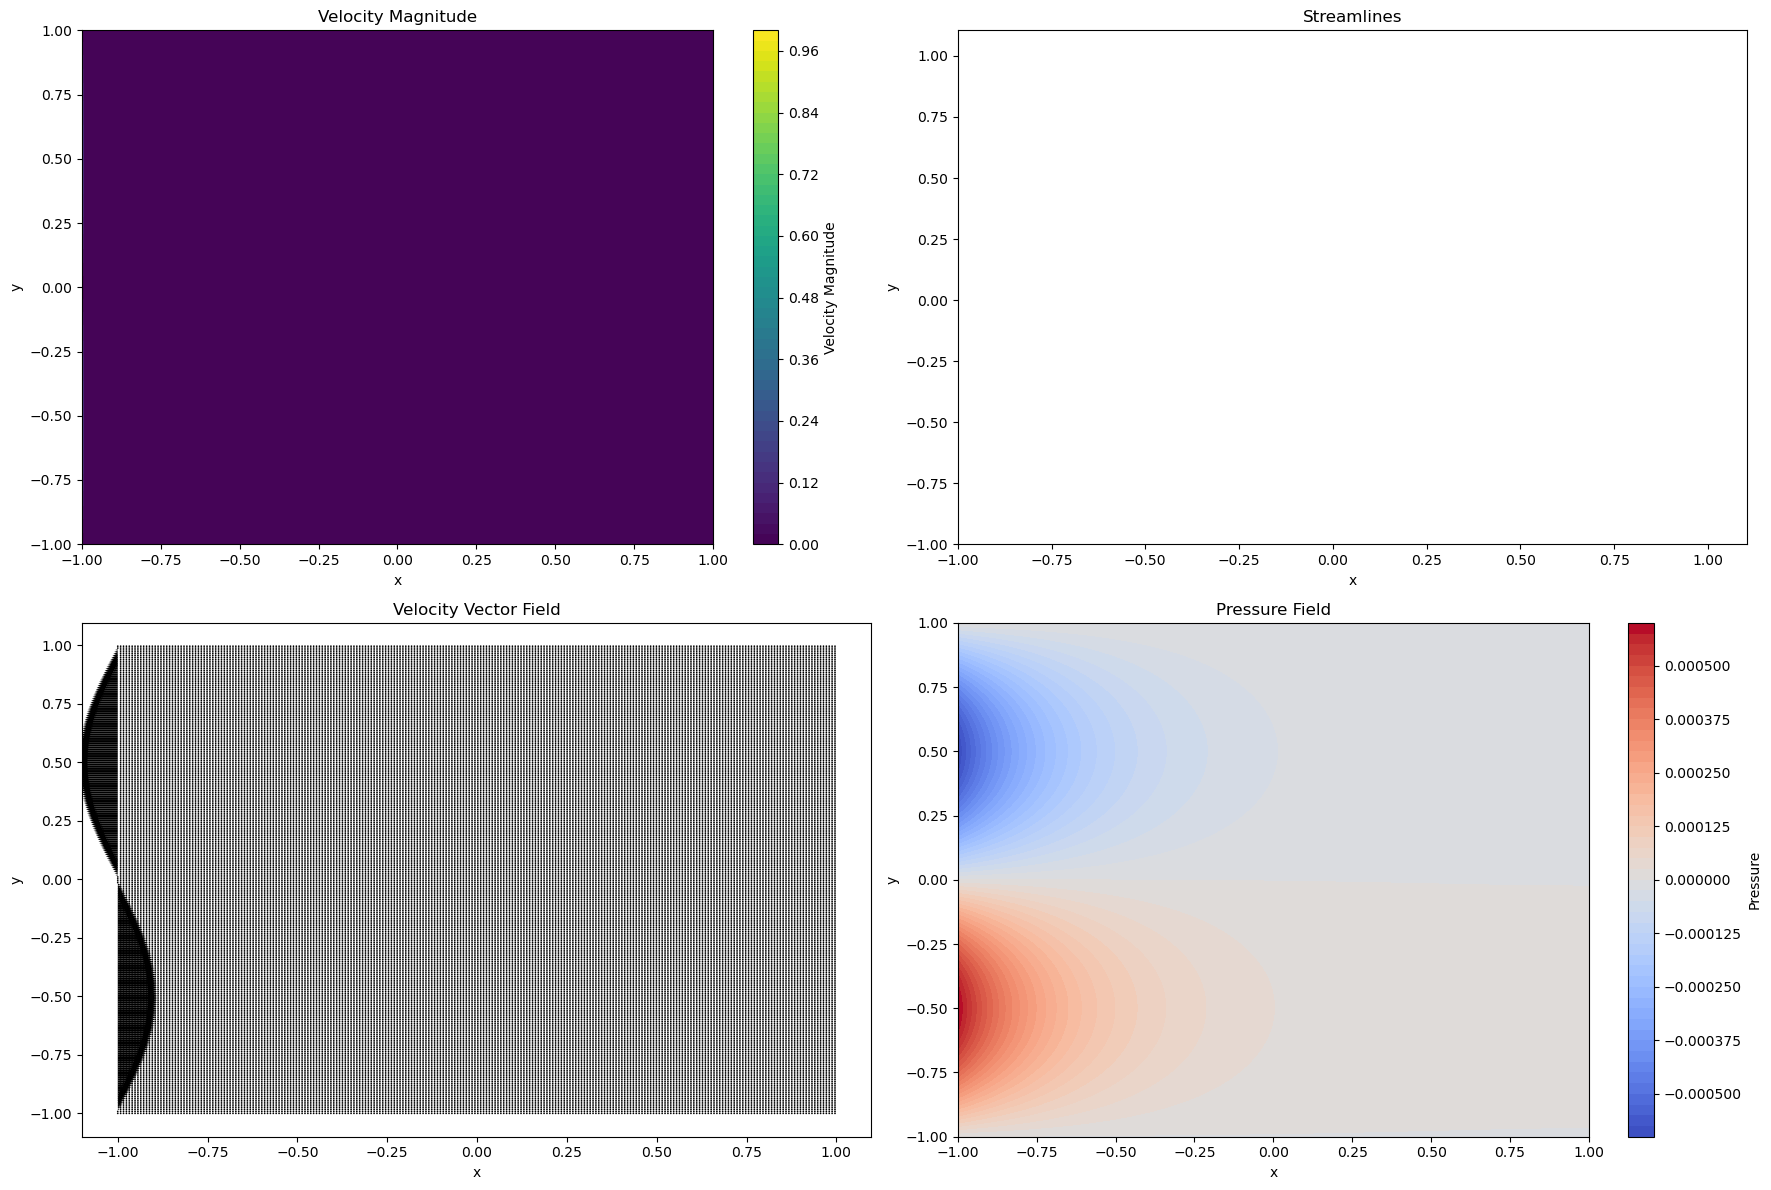

In [ ]:
print("\nBoundary condition verification:")
print(f"Left boundary (x=-1): u = {u[0, ny//2]:.4f} (should be -sin(πy))")
print(f"Right boundary (x=1): u = {u[-1, ny//2]:.4f} (should be 0)")
print(f"Bottom boundary (y=-1): v = {v[nx//2, 0]:.4f} (should be 0)")
print(f"Top boundary (y=1): v = {v[nx//2, -1]:.4f} (should be 0)")

plt.figure(figsize=(18, 12))

# 速度大小
speed = np.sqrt(u**2 + v**2)

# 修复流线图问题：使用转置和正确的网格
plt.subplot(221)
plt.contourf(X, Y, speed, cmap='viridis', levels=50)
plt.colorbar(label='Velocity Magnitude')
plt.title('Velocity Magnitude')
plt.xlabel('x')
plt.ylabel('y')

# 流线图 - 使用一维坐标
plt.subplot(222)
plt.streamplot(x, y, u.T, v.T, color='white', density=1.5, linewidth=0.7)
plt.title('Streamlines')
plt.xlabel('x')
plt.ylabel('y')

# 速度矢量场
plt.subplot(223)
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2], scale=20)
plt.title('Velocity Vector Field')
plt.xlabel('x')
plt.ylabel('y')

# 压力场
plt.subplot(224)
plt.contourf(X, Y, p, cmap='coolwarm', levels=50)
plt.colorbar(label='Pressure')
plt.title('Pressure Field')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.savefig('burgers_solution.png', dpi=300)
plt.show()